# Classification models - unsupervised discretization

Dataset: tranfusion <br>
By: Sam <br>
Update at: 07/03/2023 <br>

====

Summary:<br>
- Import unsupervised discretised datasets (already encoded categorical attributes)
- Split dataset: 75% training, 25% testing, seed = 30
- Class imbalance: Using SMOTE-ENN for training data
- Perform 3 classification models: ID3, Categorical Naive Bayes, Knn-Hamming
**For categorical Naive Bayes: passing number of categories of features in the parameter min_categories to avoid index out of bound error**
- Evaluation on testing data: Classification report (accuracy, precision, recall, f1-score) + G-mean
- Export models after training: CNB models - joblib; ID3 & Knn-Hamming: skops
- Write models performance to file: 'transfusion_models.txt'.

### About Dataset
Attribute Information:
Given is the variable name, variable type, the measurement unit and a brief  description. The "Blood Transfusion Service Center" is a classification problem. 
The order of this listing corresponds to the order of numerals along the rows of  the database.
- R (Recency - months since last donation),
- F (Frequency - total number of donation),
- M (Monetary - total blood donated in c.c.),
- T (Time - months since first donation),

LABEL: a binary variable representing whether he/she donated blood in March 2007 
- 1 stand for donating blood
- 0 stands for not donating blood

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import set_option
import numpy as np
from numpy import arange
## EDA
from collections import Counter

In [2]:
# Pre-processing
from sklearn.preprocessing import OrdinalEncoder
# Cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score # 1 metric
from sklearn.model_selection import cross_validate # more than 1 metric
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
# For Naive Bayes
from sklearn.naive_bayes import CategoricalNB # Categorical Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Multinominal Naive Bayes (suitable for NLP)
from mixed_naive_bayes import MixedNB # Mixed Naive Bayes for combination of both discrete & continuous feature

In [4]:
# For decision tree ID3 
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from id3 import Id3Estimator # ID3 Decision Tree (https://pypi.org/project/decision-tree-id3/)
from id3 import export_graphviz

In [5]:
# Knn-VDM 3
from vdm3 import ValueDifferenceMetric
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# For model evaluation
from sklearn.metrics import classification_report
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. EWD data

## 1.1 EWD, k = 4

In [8]:
# Complete code for data preperation
# Read data
df_ewd1 = pd.read_csv('tranfusion_ewd1.csv')
disc = 'EWD'
k = 4

df_ewd1.info()
data = df_ewd1.values
data.shape

features = df_ewd1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]
#X = df_ewd1[features]
#Y = df_ewd1['label']

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ewd1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

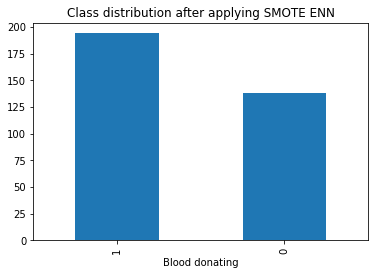

In [9]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models - EWD, k=4

In [10]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 4'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_EWD_4.skops


In [11]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 4'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_EWD_4.sav


['tranfusion_CNB_EWD_4.sav']

In [12]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 4'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_EWD_4.skops


## 1.2 EWD, k = 7

### Data prep

In [13]:
# Complete code for data preperation
# Read data
df_ewd2 = pd.read_csv('tranfusion_ewd2.csv')
disc = 'EWD'
k = 7

df_ewd2.info()
data = df_ewd2.values
data.shape

features = df_ewd2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ewd2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

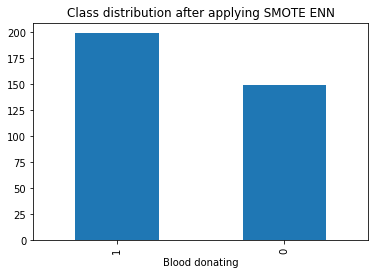

In [14]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models - EWD, k=7

In [15]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 7'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_EWD_7.skops


In [16]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 7'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_EWD_7.sav


['tranfusion_CNB_EWD_7.sav']

In [17]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 7'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_EWD_7.skops


## 1.3 EWD, k = 10

### Data prep

In [18]:
## 1.3 EWD, k = 10

# Complete code for data preperation
# Read data
df_ewd3 = pd.read_csv('tranfusion_ewd3.csv')
disc = 'EWD'
k = 10

df_ewd3.info()
data = df_ewd3.values
data.shape

features = df_ewd3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ewd3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

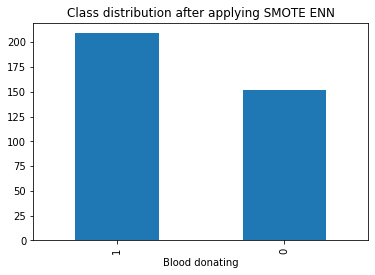

In [19]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models - EWD, k=10

In [20]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_EWD_10.skops


In [21]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models

import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_EWD_10.sav


['tranfusion_CNB_EWD_10.sav']

In [22]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'EWD'
disc_param = 'k = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_EWD_10.skops


# 2. EFD datasets

## 2.1 EFD, k = 4

### Data prep

In [23]:
# Complete code for data preperation
# Read data
df_efd1 = pd.read_csv('tranfusion_efd1.csv')
disc = 'EFD'
k = 4

df_efd1.info()
data = df_efd1.values
data.shape

features = df_efd1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_efd1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 425, 1: 136})
Class representation - testing data:  Counter({0: 145, 1: 42})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

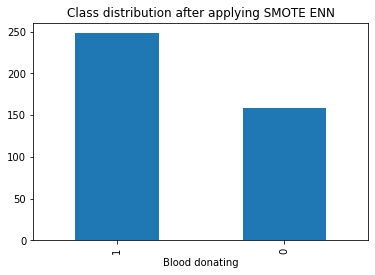

In [24]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models - EFD, k=4

In [25]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 4'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_EFD_4.skops


In [26]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 4'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_EFD_4.sav


['tranfusion_CNB_EFD_4.sav']

In [27]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 4'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_EFD_4.skops


## 2.2 EFD, k = 7

### Data prep

In [28]:
# Complete code for data preperation
# Read data
df_efd2 = pd.read_csv('tranfusion_efd2.csv')
disc = 'EFD'
k = 7

df_efd2.info()
data = df_efd2.values
data.shape

features = df_efd2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_efd2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 425, 1: 136})
Class representation - testing data:  Counter({0: 145, 1: 42})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

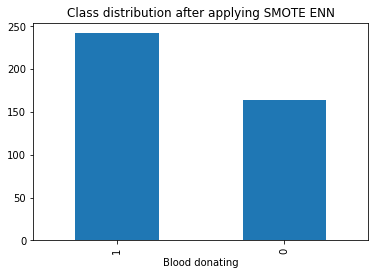

In [29]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models, EFD, k=7

In [30]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 7'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_EFD_7.skops


In [31]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 7'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_EFD_7.sav


['tranfusion_CNB_EFD_7.sav']

In [32]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 7'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_EFD_7.skops


## 2.3 EFD, k = 10

In [33]:
### Dataprep

In [34]:
# Complete code for data preperation
# Read data
df_efd3 = pd.read_csv('tranfusion_efd3.csv')
disc = 'EFD'
k = 10

df_efd3.info()
data = df_efd3.values
data.shape

features = df_efd3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_efd3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 425, 1: 136})
Class representation - testing data:  Counter({0: 145, 1: 42})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

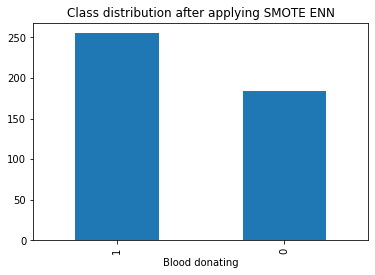

In [35]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models, EFD, k=10

In [36]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_EFD_10.skops


In [37]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_EFD_10.sav


['tranfusion_CNB_EFD_10.sav']

In [38]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'EFD'
disc_param = 'k = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_EFD_10.skops


# 3. FFD datasets

## 3.1 FFD, m =10 (tranfusion_ffd1)

### Data prep

In [39]:
# Complete code for data preperation
# Read data
df_ffd1 = pd.read_csv('tranfusion_ffd1.csv')
disc = 'FFD'
m = 10

df_ffd1.info()
data = df_ffd1.values
data.shape

features = df_ffd1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

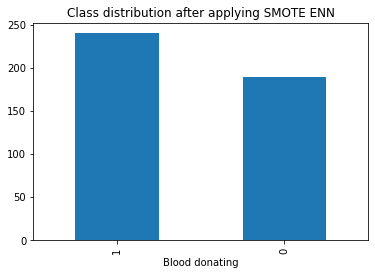

In [40]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models, FFD, m = 10

In [41]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_FFD_10.skops


In [42]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)


tranfusion_CNB_FFD_10.sav


['tranfusion_CNB_FFD_10.sav']

In [43]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 10'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_FFD_10.skops


## 3.1 FFD, m =30 (tranfusion_ffd2)

### Data prep

In [44]:
# Complete code for data preperation
# Read data
df_ffd2 = pd.read_csv('tranfusion_ffd2.csv')
disc = 'FFD'
m = 30

df_ffd2.info()
data = df_ffd2.values
data.shape

features = df_ffd2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

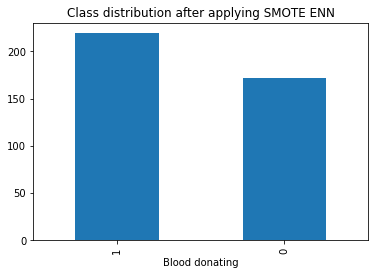

In [45]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models, FFD, m = 30

In [46]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 30'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_FFD_30.skops


In [47]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 30'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_FFD_30.sav


['tranfusion_CNB_FFD_30.sav']

In [48]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 30'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_FFD_30.skops


## 3.3 FFD, m =60 (tranfusion_ffd3)

### Data prep

In [49]:
# Complete code for data preperation
# Read data
df_ffd3 = pd.read_csv('tranfusion_ffd3.csv')
disc = 'FFD'
m = 60

df_ffd3.info()
data = df_ffd3.values
data.shape

features = df_ffd3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

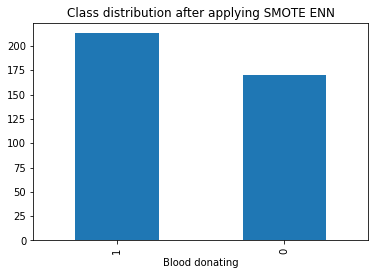

In [50]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models, FFD, m = 60

In [51]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 60'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_FFD_60.skops


In [52]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 60'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_FFD_60.sav


['tranfusion_CNB_FFD_60.sav']

In [53]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 60'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_FFD_60.skops


## 3.3 FFD, m =100 (tranfusion_ffd4)

### Data prep

In [54]:
# Complete code for data preperation
# Read data
df_ffd4 = pd.read_csv('tranfusion_ffd4.csv')
disc = 'FFD'
m = 100

df_ffd4.info()
data = df_ffd4.values
data.shape

features = df_ffd4.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd4[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  748 non-null    int64
 1   recency     748 non-null    int64
 2   frequency   748 non-null    int64
 3   monetary    748 non-null    int64
 4   time        748 non-null    int64
 5   label       748 non-null    int64
dtypes: int64(6)
memory usage: 35.2 KB
(748, 5) (748,)
Class representation - original:  Counter({0: 570, 1: 178})
Class representation - training data:  Counter({0: 428, 1: 133})
Class representation - testing data:  Counter({0: 142, 1: 45})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE ENN'}, xlabel='Blood donating'>

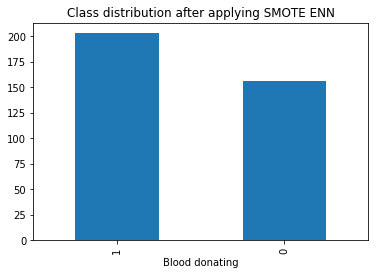

In [55]:
from imblearn.combine import SMOTEENN
smt_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smt_enn.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE ENN', xlabel='Blood donating')

### Models, FFD, m = 100

In [56]:
# ID3 - Default
model = 'ID3'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 100'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

tranfusion_ID3_FFD_100.skops


In [57]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 100'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)

tranfusion_CNB_FFD_100.sav


['tranfusion_CNB_FFD_100.sav']

In [58]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'tranfusion'
discretizer = 'FFD'
disc_param = 'm = 100'

f = open("tranfusion_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

tranfusion_KNN-Hamming_FFD_100.skops
